# Variational Autoencoder (VAE)

* Теперь мы будем с помощью кодировщика предсказывать не конкретную точку $z$ в латентном представлении, а распределение $q(z | x)$

* Также будем требовать, чтобы наше латентное представление было многомерным нормальным распределением $\mathcal{N} (\mu, \sigma)$ с параметрами среднего и дисперсии, которые будут получаться из энкодера

Технически разница будет в том, что после энкодинга объекта нам нужно будет получить не один вектор, а два.

Функция потерь для VAE выглядит так:

$$
\sum_{i = 1}^{\ell} \left( \mathbb{E}_{q(z|x_i)} \log p(x_i | z) - KL(q(z | x_i) \; || \; \mathcal{N}(0, 1)) \right) \to max.
$$

Как же на практике вычислить такой лосс?
- В нашей реализации мы максимально упростим вычисление матожидания: будем оценивать его по одному семплу
- Помимо всего этого, на выходе из VAE обычно предсказывают не напрямую реконструкцию объекта, а параметры `mu_reconstruction` и `sigma_reconstruction` для распределения этой самой реконструкции.
Мы и тут упростим себе задачу тем, что вместо распределения будем предказывать точечную оценку реконструкции абсолютно аналогично тому, что происходило в обычных автокодировщиках.

В такой постановке первое слагаемое лосса станет просто MSE между исходным объектом и восстановленным.

In [ ]:
from typing import Type, Union

import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision
import torchvision.transforms as transforms
from IPython.display import clear_output, display
from ipywidgets import Output
from torch import nn, optim
from tqdm.auto import trange

%matplotlib inline

device = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
class MNISTEncoder_vae(nn.Module):
    def __init__(self, lat_size: int):
        super().__init__()

        self.lat_size = lat_size

        self.enc = nn.Sequential(
            nn.Flatten(), nn.Linear(784, 512), nn.ReLU(), nn.Linear(512, 256), nn.ReLU()
        )

        self.mu = nn.Linear(256, self.lat_size)
        self.log_sigma = nn.Linear(256, self.lat_size)

    def forward(self, x: torch.Tensor):
        z = self.enc(x)
        mu, log_sigma = self.mu(z), self.log_sigma(z)

        return mu, log_sigma


class MNISTDecoder_vae(nn.Module):
    def __init__(self, lat_size: int):
        super().__init__()

        self.lat_size = lat_size

        self.dec = nn.Sequential(
            nn.Linear(self.lat_size, 128), nn.ReLU(), nn.Linear(128, 784), nn.Sigmoid()
        )

    def forward(self, z: torch.Tensor):
        x_reconstructed = self.dec(z)
        x_reconstructed = x_reconstructed.view(-1, 1, 28, 28)

        return x_reconstructed

In [ ]:
class VariationalAutoEncoder(nn.Module):
    def __init__(
        self,
        lat_size: int,
        KL_weight: float = 0.001,
        encoder_class: Type[MNISTEncoder_vae] = MNISTEncoder_vae,
        decoder_class: Type[MNISTDecoder_vae] = MNISTDecoder_vae,
        criterion_class: Type[nn.MSELoss] = nn.MSELoss,
    ) -> None:
        super().__init__()

        self.lat_size = lat_size
        self.enc = encoder_class(lat_size)
        self.dec = decoder_class(lat_size)
        self.criterion = criterion_class()
        self.k = 0
        self.KL_weight = KL_weight

    def encode(self, x: torch.Tensor) -> torch.Tensor:
        return self.enc(x)

    def decode(self, z: torch.Tensor) -> torch.Tensor:
        return self.dec(z)

    def sample_z(self, mu: torch.Tensor, log_sigma: torch.Tensor) -> torch.Tensor:
        eps = torch.randn(mu.size(), device=mu.device)

        return mu + torch.exp(log_sigma / 2) * eps

    def custom_loss(
        self,
        x: torch.Tensor,
        reconstructed_x: torch.Tensor,
        mu: torch.Tensor,
        log_sigma: torch.Tensor,
    ) -> torch.Tensor:
        KL = torch.mean(
            -0.5 * torch.sum(1 + log_sigma - mu**2 - log_sigma.exp(), dim=1), dim=0
        )
        reconstruction_loss = self.criterion(x, reconstructed_x)

        return KL * self.KL_weight + reconstruction_loss

    def compute_loss(
        self, x: torch.Tensor, return_reconstruction: bool = False
    ) -> Union[tuple[torch.Tensor, torch.Tensor], torch.Tensor]:
        mu, log_sigma = self.encode(x)
        z = self.sample_z(mu, log_sigma)
        reconstructed_x = self.decode(z)

        loss = self.custom_loss(x, reconstructed_x, mu, log_sigma)

        if return_reconstruction:
            return loss, reconstructed_x
        else:
            return loss

Загрузим данные

In [ ]:
transform = transforms.Compose([transforms.ToTensor()])

train_dataset = torchvision.datasets.MNIST(
    root="./mnist", train=True, download=True, transform=transform
)
test_dataset = torchvision.datasets.MNIST(
    root="./mnist", train=False, download=True, transform=transform
)

train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=256, shuffle=True, num_workers=1
)
test_dataloader = torch.utils.data.DataLoader(
    test_dataset, batch_size=256, shuffle=False, num_workers=1
)

100%|██████████| 9.91M/9.91M [00:00<00:00, 11.5MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 338kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 3.17MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 6.31MB/s]


In [ ]:
def train_epoch(
    model: nn.Module,
    train_dataloader: torch.utils.data.DataLoader,
    optimizer: torch.optim.Optimizer,
    verbose_num_iters: int = 32,
    device: torch.device = "cuda",
) -> list[float]:
    model.to(device)
    model.train()
    epoch_loss_trace = []

    display()
    out = Output()
    display(out)

    for i, batch in enumerate(train_dataloader):
        x, y = batch
        x = x.to(device)

        loss, reconstructed_x = model.compute_loss(x, return_reconstruction=True)

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        epoch_loss_trace.append(loss.item())

        if (i + 1) % verbose_num_iters == 0:
            with out:
                clear_output(wait=True)

                plt.figure(figsize=(10, 5))
                plt.subplot(1, 2, 1)
                plt.title("Current epoch loss", fontsize=22)
                plt.xlabel("Iteration", fontsize=16)
                plt.ylabel("Reconstruction loss", fontsize=16)
                plt.grid()
                plt.plot(epoch_loss_trace)

                for j in range(3):
                    plt.subplot(2, 6, 4 + j)
                    plt.axis("off")
                    plt.imshow(x[j, 0].cpu().detach().numpy(), cmap="gray")

                    plt.subplot(2, 6, 10 + j)
                    plt.axis("off")
                    plt.imshow(
                        reconstructed_x[j, 0].cpu().detach().numpy(), cmap="gray"
                    )

                plt.show()

    out.clear_output()

    return epoch_loss_trace


def train_model(
    model: nn.Module,
    train_dataloader: torch.utils.data.DataLoader,
    optimizer: torch.optim.Optimizer,
    num_epochs: int = 5,
    verbose_num_iters: int = 32,
    device: torch.device = "cuda",
) -> None:
    loss_trace = []
    for epoch in trange(num_epochs, desc="Epoch: ", leave=True):
        epoch_loss_trace = train_epoch(
            model=model,
            train_dataloader=train_dataloader,
            optimizer=optimizer,
            verbose_num_iters=verbose_num_iters,
            device=device,
        )

        loss_trace += epoch_loss_trace

    plt.figure(figsize=(10, 5))
    plt.title("Total training loss", fontsize=22)
    plt.xlabel("Iteration", fontsize=16)
    plt.ylabel("Reconstruction loss", fontsize=16)
    plt.grid()
    plt.plot(loss_trace)
    plt.show()

    model.eval()

Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

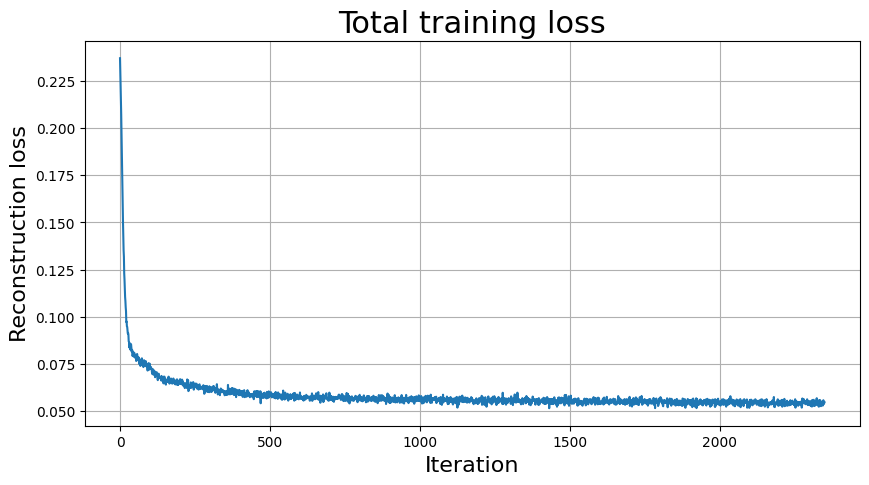

In [ ]:
hidden_dim = 2
model_vae = VariationalAutoEncoder(hidden_dim, 0.002)
optimizer = optim.Adam(model_vae.parameters(), lr=1e-3)

train_model(model_vae, train_dataloader, optimizer, 10)

### Интерполяция латентных кодов

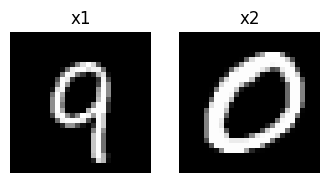

In [ ]:
x, _ = next(iter(train_dataloader))

x1 = x[0].to(device)
x2 = x[1].to(device)
fig, axs = plt.subplots(1, 2, figsize=(4, 2))

axs[0].axis("off")
axs[0].set_title("x1")
axs[0].imshow(x1[0].cpu().detach().numpy(), cmap="gray")
axs[1].axis("off")
axs[1].set_title("x2")
axs[1].imshow(x2[0].cpu().detach().numpy(), cmap="gray");

In [ ]:
# латентные коды объектов
z_1_mu, z_1_logs = model_vae.encode(x1[None, :, :, :])
z_2_mu, z_2_logs = model_vae.encode(x2[None, :, :, :])
z_1 = model_vae.sample_z(z_1_mu, z_1_logs)
z_2 = model_vae.sample_z(z_2_mu, z_2_logs)

# батч с интерполяцией этих латентных кодов по прямой в 11 точках
linspace = torch.linspace(0, 1, 11)[:, None].to(device)
z_linspace = z_2 * linspace + z_1 * (1 - linspace)

# восстановленные из латентных кодов изображения
x_linspace = model_vae.decode(z_linspace)

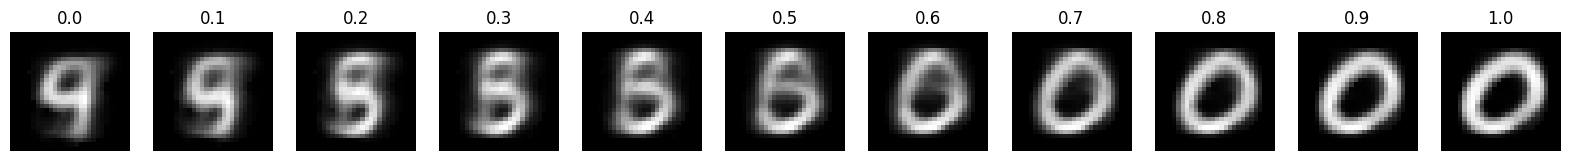

In [ ]:
# рисуем проинтерполированные объекты
fig, axs = plt.subplots(1, 11, figsize=(20, 20))

for i, d in enumerate(np.linspace(0, 1, 11)):
    axs[i].axis("off")
    axs[i].set_title(f"{d:.2}")
    axs[i].imshow(x_linspace[i, 0].cpu().detach().numpy(), cmap="gray")